In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
index_list = np.linspace(0,3749, 3750).astype(np.uint16)
np.random.shuffle(index_list)
index_list = index_list
print(index_list)

[2080 1636 2206 ... 1539 1514  819]


In [3]:
locloc = "BigDataPeople" 
namename = "\Suitman_EEVEE\\SuitMan"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_depths = np.load(locloc + namename + 'Depth.npy')[:,:,:,0]
all_masks = np.load(locloc + namename + 'Masks.npy')
all_vectors = np.load(locloc + namename + 'Vectors.npy')
# Цель просто сделать рабочий генератор маски.

In [4]:
locloc = "BigDataPeople" 
namename = "\Knight_EEVEE\\Knight"
all_photos1 = np.load(locloc + namename + 'Photos.npy')
all_albedos1 = np.load(locloc + namename + 'Albedos.npy')
all_normals1 = np.load(locloc + namename + 'Normals.npy')
all_depths1 = np.load(locloc + namename + 'Depth.npy')[:,:,:,0]
all_masks1 = np.load(locloc + namename + 'Masks.npy')
all_vectors1 = np.load(locloc + namename + 'Vectors.npy')

In [5]:
locloc = "BigDataPeople" 
namename = "\Woman1_EEVEE\\Woman1"
all_photos2 = np.load(locloc + namename + 'Photos.npy')
all_albedos2 = np.load(locloc + namename + 'Albedos.npy')
all_normals2 = np.load(locloc + namename + 'Normals.npy')
all_depths2 = np.load(locloc + namename + 'Depth.npy')[:,:,:,0]
all_masks2 = np.load(locloc + namename + 'Masks.npy')
all_vectors2 = np.load(locloc + namename + 'Vectors.npy')

In [6]:
all_photos = np.concatenate([all_photos, all_photos1, all_photos2], axis=0) 
all_albedos = np.concatenate([all_albedos, all_albedos1, all_albedos2], axis=0) 
all_normals = np.concatenate([all_normals, all_normals1, all_normals2], axis=0) 
all_depths = np.concatenate([all_depths, all_depths1, all_depths2], axis=0) 
all_masks = np.concatenate([all_masks, all_masks1, all_masks2], axis=0) 
all_vectors = np.concatenate([all_vectors, all_vectors1, all_vectors2], axis=0) 
del all_photos1;  del all_photos2;
del all_albedos1; del all_albedos2;
del all_normals1; del all_normals2;
del all_depths1; del all_depths2;
del all_masks1;   del all_masks2;
del all_vectors1; del all_vectors2

In [7]:
all_photos = all_photos[index_list]
all_albedos = all_albedos[index_list]
all_normals = all_normals[index_list]
all_depths = all_depths[index_list]
all_masks = all_masks[index_list]
all_vectors = all_vectors[index_list]

In [8]:
all_normal_depth = np.stack([all_normals[:,:,:,0], all_normals[:,:,:,1], all_normals[:,:,:,2], all_depths], axis = 3)
del all_depths; del all_normals;

In [9]:
ratio = 0.96; 
all_length = round( len(all_photos) * ratio)

all_photos_test = all_photos[all_length:]
all_albedos_test = all_albedos[all_length:]
all_normal_depth_test = all_normal_depth[all_length:]
all_mask_test = all_masks[all_length:]
all_vectors_test = all_vectors[all_length:]

all_photos = all_photos[0: all_length]
all_albedos = all_albedos[0: all_length]
all_normal_depth = all_normal_depth[0: all_length]
all_masks = all_masks[0: all_length]
all_vectors = all_vectors[0: all_length]

In [10]:
def GetDifference(num_images):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images]
    mask = all_masks[num_images]
    return photo - albedo * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nmax = 0.01
    if nonneg.max() != 0:
        nmax = nonneg.max()
    nonneg = nonneg * (1.0/nmax)
    return nonneg# * mask
def getDepth(image4D):
    last_layer = image4D[:,:,3]
    return np.stack([last_layer,last_layer,last_layer], axis = 2)

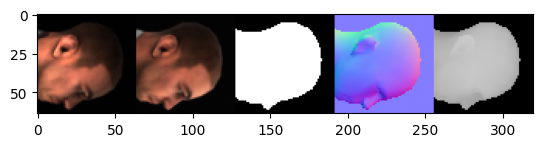

In [11]:
numberouno = 25
plt.imshow(np.concatenate([all_photos[numberouno], all_albedos[numberouno], all_masks[numberouno], all_normal_depth[numberouno, :,:,:3], getDepth(all_normal_depth[numberouno])], axis = 1).astype(np.float32))

In [12]:
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    testanswers = all_albedos[mylist]
    imgimg = locmodel.predict([inputs])
    testanswers2 = all_albedos[mylist]
    imgimg2 = locmodel.predict([inputs])
    for i in range(len(mylist)):
        testanswers2[i] = normalizeNegativeImage(all_albedos[mylist[i]], all_masks[mylist[i]])
        imgimg2[i] = normalizeNegativeImage(imgimg[i], all_masks[mylist[i]])

    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(testanswers, axis=1)
    r2 =  np.concatenate(imgimg, axis=1)
    r3 =  np.concatenate(testanswers2, axis=1)
    r4 =  np.concatenate(imgimg2, axis=1)
    finalimage = np.concatenate([r0, r0 - r1, r0 - r2, r3, r4], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [13]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно
 
all_diffs = list()
all_diffs_test = list()
print(len(all_photos))
for i in range(len(all_photos)):
    all_diffs.append(
        GetDifference(i)
    )        
for i in range(len(all_photos_test)):
    photo = all_photos_test[i]
    albedo = all_albedos_test[i]
    mask = all_mask_test[i]
    result =  photo - albedo * mask
    
    all_diffs_test.append(
        result
    )  
all_diffs = np.array(all_diffs)
all_diffs_test = np.array(all_diffs_test)

datasetX = tf.data.Dataset.from_tensor_slices((all_normal_depth, all_vectors))
datasetY = tf.data.Dataset.from_tensor_slices(all_diffs)

dataset = tf.data.Dataset.zip((datasetX, datasetY))
dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_normal_depth.shape, all_albedos.shape)

3600
(3600, 64, 64, 4) (3600, 64, 64, 3)


In [14]:
del all_photos; del all_photos_test;

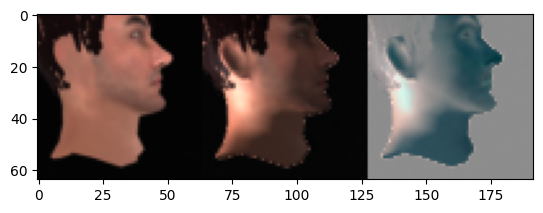

In [15]:
plt.imshow(np.concatenate([
    all_albedos[500].astype("float32"), 
    all_albedos[500].astype("float32") + all_diffs[500], 
    normalizeNegativeImage(all_diffs[500], all_masks[500])]
                          , axis = 1))

In [16]:
def ConvBlock(inputs, filters=64):
    conv1 = keras.layers.Conv2D(filters, kernel_size = (3,3), activation="tanh", padding = "same")(inputs)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    
    conv2 = keras.layers.Conv2D(filters, kernel_size = (3,3), activation="tanh", padding = "same")(batch_norm1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)

    return batch_norm2
def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(inputs, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out
def get_U_Net(image_size):
    image_input = keras.layers.Input(image_size, name='image_input')
    
    skip1, encoder_1 = encoder(image_input, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*4)

    vector_input = keras.layers.Input(shape=(3,), name='vector_input')
    vector = keras.layers.Dense(256, activation='relu', name ="vector_extended")(vector_input)
    
    conv_block = ConvBlock(encoder_4, 32*4)
    flatten = keras.layers.Flatten()(conv_block)
    combined = keras.layers.concatenate([flatten, vector])
    
    dense1 = keras.layers.Dense(16*16*4, activation="tanh") (combined)
    dense2 = keras.layers.Dense(32*32, activation="tanh") (dense1)
    reshape = keras.layers.Reshape((4, 4, 4 * 4 * 4))(dense2)
    
    decoder_1 = decoder(reshape, skip4, 32*4)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    outputs = keras.layers.Conv2D(3, 1, padding="same", activation="tanh")(decoder_4)
    
    model = keras.models.Model(inputs = [image_input, vector_input], outputs = outputs)
    return model

In [17]:
'''
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 4), name='image_input')
    x = keras.layers.Conv2D(6, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    vector_input = keras.layers.Input(shape=(3,), name='vector_input')
    y = keras.layers.Dense(256, activation='relu')(vector_input)
    
    # Объединение выходов
    combined = keras.layers.concatenate([x, y])
    
    # Полносвязный слой
    z = keras.layers.Dense(4*16*24, activation='tanh')(combined)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*24, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*24, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*24, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*32*32, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((8,8, 4 * 4 * 4))(do)
    #anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input, vector_input], outputs=output)
    return model'''

'\ndef GiveModel():\n    image_input = keras.layers.Input(shape=(64, 64, 4), name=\'image_input\')\n    x = keras.layers.Conv2D(6, (3, 3), activation=\'relu\', padding="same")(image_input)\n    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)\n    x = keras.layers.Conv2D(8, (3, 3), activation=\'relu\', padding="same")(x)\n    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)\n    x = keras.layers.Flatten()(x)\n    \n    vector_input = keras.layers.Input(shape=(3,), name=\'vector_input\')\n    y = keras.layers.Dense(256, activation=\'relu\')(vector_input)\n    \n    # Объединение выходов\n    combined = keras.layers.concatenate([x, y])\n    \n    # Полносвязный слой\n    z = keras.layers.Dense(4*16*24, activation=\'tanh\')(combined)\n    do = keras.layers.Dropout(0.4)(z)\n    z = keras.layers.Dense(6*16*24, activation=\'tanh\')(do)\n    do = keras.layers.Dropout(0.4)(z)\n    z = keras.layers.Dense(6*16*24, activation=\'tanh\')(do)\n    do = keras.layers.Dropout(0.4)(z)\n    z = keras

In [18]:
#g_optimizer_image = keras.optimizers.Adam(learning_rate=0.000015)
#g_optimizer_image = keras.optimizers.Adam(learning_rate=0.000005)
g_optimizer_image = keras.optimizers.Adam(learning_rate=0.0000012)

In [19]:
model = get_U_Net((64,64,4))
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   1184        ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['batch_normalization[0][0]']

In [79]:
'''model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()'''

"model = GiveModel()\nmodel.compile(optimizer=g_optimizer_image, loss='mse')\nmodel.summary()"

In [309]:
model.fit(train_dataset, epochs=10)

Epoch 1/10
56/56 [==============================] - 5s 77ms/step - loss: 0.0093
Epoch 2/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0093
Epoch 3/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0093
Epoch 4/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0092
Epoch 5/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0092
Epoch 6/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0091
Epoch 7/10
56/56 [==============================] - 4s 72ms/step - loss: 0.0092
Epoch 8/10
56/56 [==============================] - 4s 72ms/step - loss: 0.0091
Epoch 9/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0091
Epoch 10/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0090


In [23]:
#plt.imshow(train_preds[0])

1/1 [==============================] - 0s 27ms/step


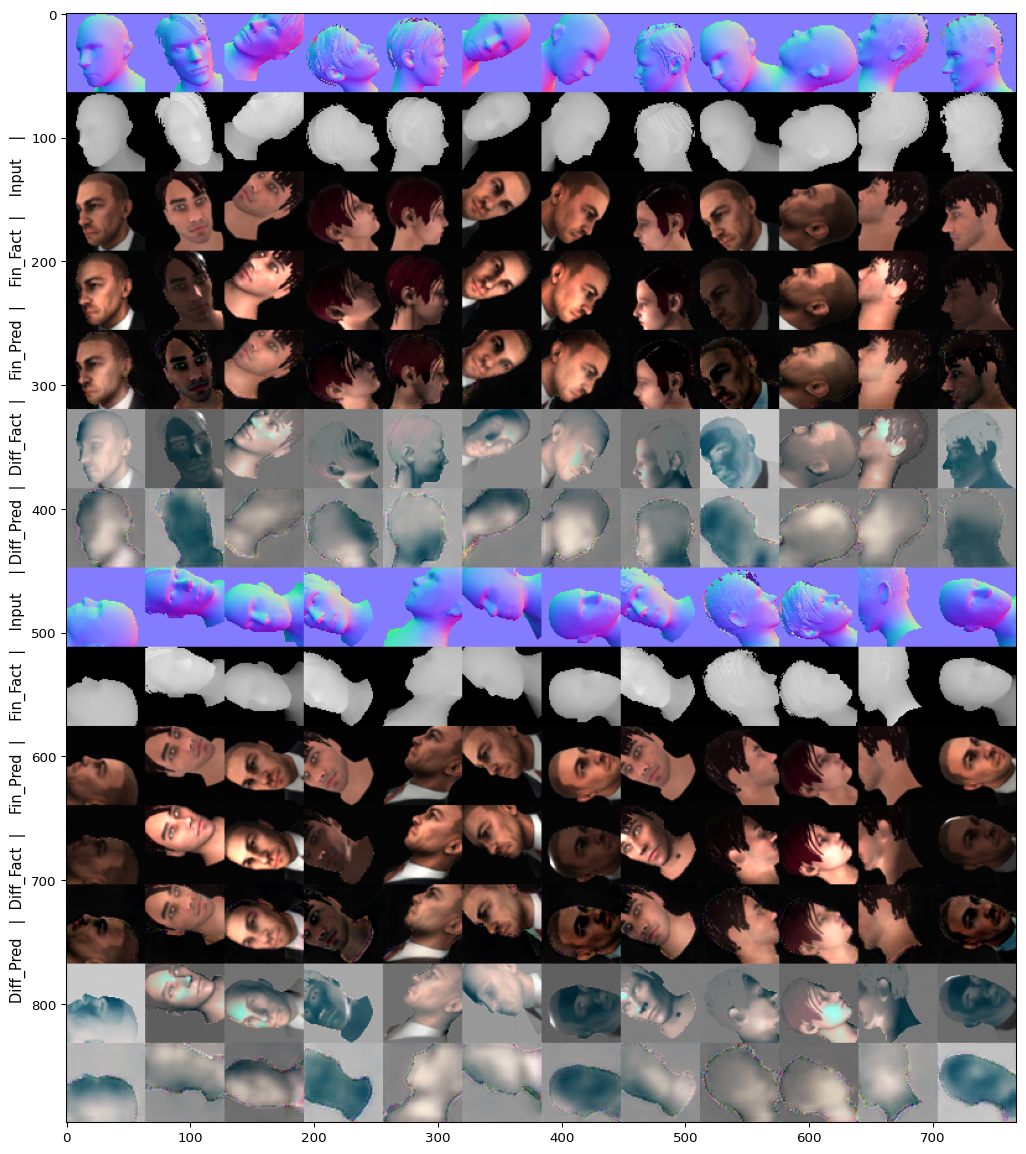

In [303]:
toinset = np.array([i * 25 for i in range(24)])
train_inputs = all_normal_depth[toinset]
train_vectors = all_vectors[toinset]
train_preds = model.predict([train_inputs, train_vectors])

train_albedos = all_albedos[toinset]
train_normals= all_normal_depth[toinset][:,:,:,:3]
train_depths = all_normal_depth[toinset][:,:,:,3]; train_depths = np.stack([train_depths,train_depths,train_depths], axis = 3)
train_diffs = all_diffs[toinset]
train_photo_real = np.clip( train_albedos + train_diffs, 0, 1)
train_photo_pred = np.clip( train_albedos + train_preds, 0, 1)

train_pred_demo = np.array([ normalizeNegativeImage(image, np.zeros((64,64,3)) + 1)  for image in train_preds])
train_diff_demo = np.array([ normalizeNegativeImage(image, np.zeros((64,64,3)) + 1)  for image in train_diffs])

bigpicture = np.concatenate([
    np.concatenate(train_normals[0:12], axis =1),
    np.concatenate(train_depths[0:12], axis =1),
    np.concatenate(train_albedos[0:12], axis =1),
    np.concatenate(train_photo_real[0:12], axis =1),
    np.concatenate(train_photo_pred[0:12], axis =1),
    np.concatenate(train_diff_demo[0:12], axis =1),
    np.concatenate(train_pred_demo[0:12], axis =1),

    np.concatenate(train_normals[12:24], axis =1),
    np.concatenate(train_depths[12:24], axis =1),
    np.concatenate(train_albedos[12:24], axis =1),
    np.concatenate(train_photo_real[12:24], axis =1),
    np.concatenate(train_photo_pred[12:24], axis =1),
    np.concatenate(train_diff_demo[12:24], axis =1),
    np.concatenate(train_pred_demo[12:24], axis =1),
], axis=0)

plt.figure(figsize=(15, 15), dpi=96)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture.astype("float32").clip(0,1))

In [310]:
model.evaluate([all_normal_depth[0:128], all_vectors[0:128]], all_diffs[0:128])
model.evaluate([all_normal_depth_test, all_vectors_test], all_diffs_test)

5/5 [==============================] - 0s 16ms/step - loss: 0.0099


0.009894521906971931

1/1 [==============================] - 0s 25ms/step


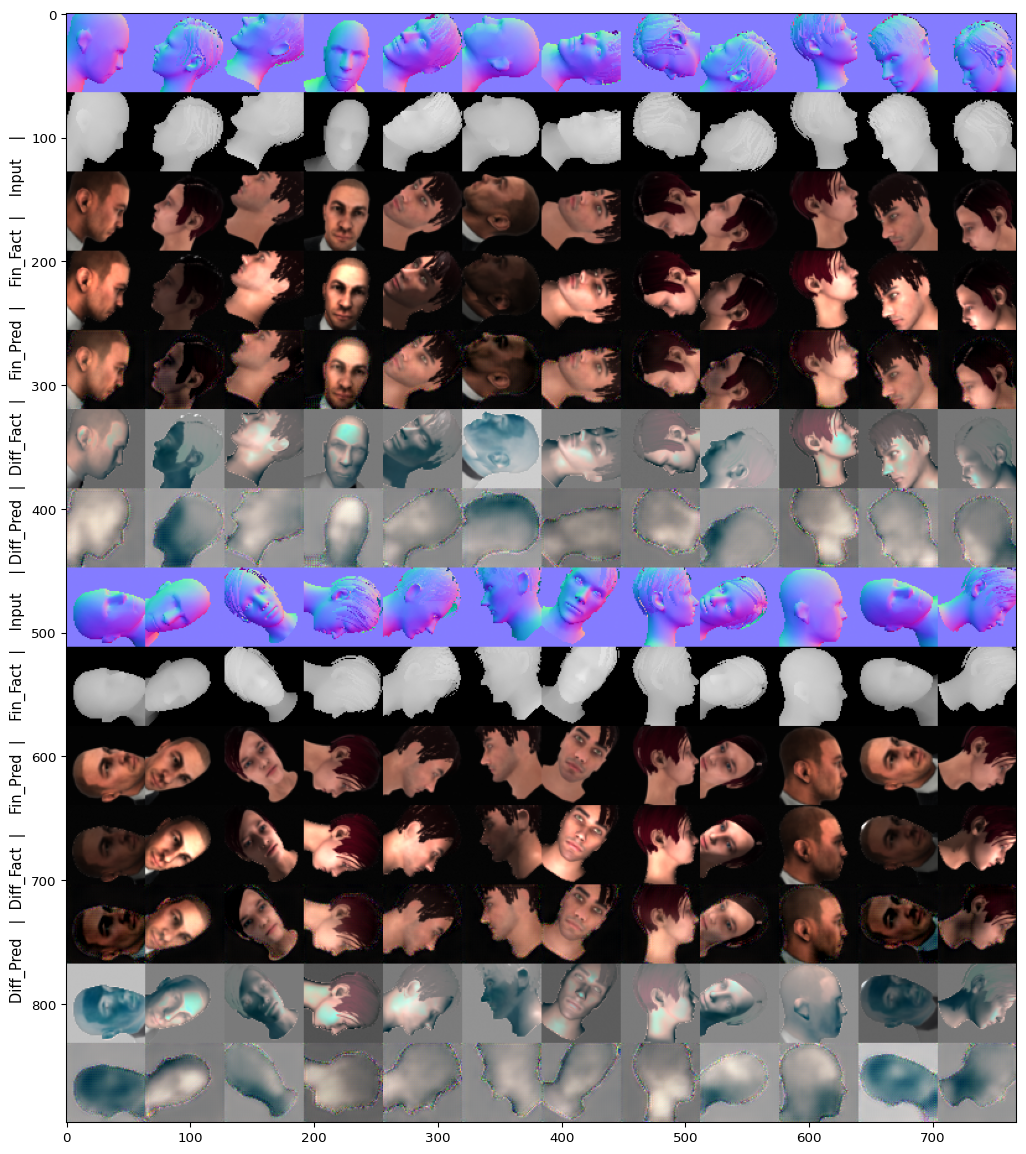

In [311]:
toinset = np.array([i * 2 for i in range(24)]); 

test_inputs = all_normal_depth_test[toinset]
test_vectors = all_vectors_test[toinset]
test_preds = model.predict([test_inputs, test_vectors])

test_albedos = all_albedos_test[toinset]
test_normals= all_normal_depth_test[toinset][:,:,:,:3]
test_depths = all_normal_depth_test[toinset][:,:,:,3]; test_depths = np.stack([test_depths,test_depths,test_depths], axis = 3)
test_diffs = all_diffs_test[toinset]
test_photo_real = test_albedos + test_diffs
test_photo_pred = test_albedos + test_preds

test_pred_demo = np.array([ normalizeNegativeImage(image, np.zeros((64,64,3)) + 1)  for image in test_preds])
test_diff_demo = np.array([ normalizeNegativeImage(image, np.zeros((64,64,3)) + 1)  for image in test_diffs])


bigpicturetest = np.concatenate([
    np.concatenate(test_normals[0:12], axis =1),
    np.concatenate(test_depths[0:12], axis =1),
    np.concatenate(test_albedos[0:12], axis =1),
    np.concatenate(test_photo_real[0:12], axis =1),
    np.concatenate(test_photo_pred[0:12], axis =1),
    np.concatenate(test_diff_demo[0:12], axis =1),
    np.concatenate(test_pred_demo[0:12], axis =1),

    np.concatenate(test_normals[12:24], axis =1),
    np.concatenate(test_depths[12:24], axis =1),
    np.concatenate(test_albedos[12:24], axis =1),
    np.concatenate(test_photo_real[12:24], axis =1),
    np.concatenate(test_photo_pred[12:24], axis =1),
    np.concatenate(test_diff_demo[12:24], axis =1),
    np.concatenate(test_pred_demo[12:24], axis =1),
], axis=0)

plt.figure(figsize=(15, 15), dpi=96)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicturetest.astype("float32").clip(0,1))

In [460]:
def points_on_circle(radius, center, num_points):
    cx, cy = center
    points = []
    for i in range(num_points):
        # Угол в радианах, равномерно распределённый, отсчёт против часовой стрелки
        angle_ccw = 2 * math.pi * i / num_points  
        # Чтобы получить движение по часовой стрелке, меняем знак угла
        angle_cw = -angle_ccw
        x = cx + radius * math.cos(angle_cw)
        y = cy + radius * math.sin(angle_cw)
        points.append((x, y))
    return points

In [ ]:
my_single_image = all_normal_depth[0]
my_single_image = my_single_image.reshape(1, 64, 64, 4)
my_single_albedo = all_albedos[0]
my_single_albedo = my_single_albedo.reshape(1, 64, 64, 3)
my_images = np.repeat(my_single_image, 24, axis= 0)
anim_albedos = np.repeat(my_single_albedo, 24, axis= 0)

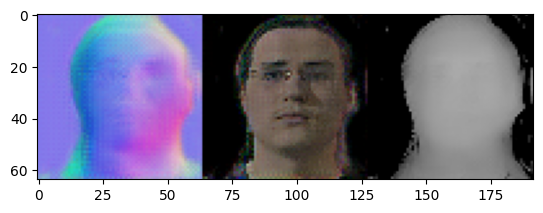

In [523]:
# Вообще работает правильно. Освещенные части оно затемнило, 
# но, из-за того что все картинки в обуч. наборе оранжевые, она затемнила синеватым цветом
dude_normal = np.array( Image.open("my_norm.png"))
dude_depth = np.array(Image.open("my_depth.png"))
dude_pic = np.array(Image.open("my_albedo.png"))
dude_normal_depth = np.array(np.stack([dude_normal[:,:, 0], dude_normal[:,:, 1], dude_normal[:,:, 2], dude_depth], axis = 2)) 
dude_normal_depth = dude_normal_depth.reshape((1,64,64,4))
dude_pic = dude_pic.reshape((1,64,64,3))

my_images = np.repeat(dude_normal_depth, 24, axis= 0) / 255
anim_albedos = np.repeat(dude_pic, 24, axis= 0) / 255

#dude_albedo = model.predict(dude_pic.reshape((1,64,64,4)))
plt.imshow(np.clip(np.concatenate([dude_normal / 255, dude_pic[0] / 255, np.stack([dude_depth,dude_depth,dude_depth], axis = 2) / 255], axis = 1), 0, 1))

In [524]:
points = points_on_circle(0.5, (0,0), 24)
#print(points)
anim_vectors = np.zeros((24, 3))
for i in range(24):
    anim_vectors[i,0] = points[i][0]
    anim_vectors[i,1] = -0.2 - points[i][0] * 0.3
    anim_vectors[i,2] = points[i][1] * 2

In [525]:
anim_preds = model.predict([my_images, anim_vectors])
anim_albedos = np.clip( anim_albedos + anim_preds * 0.8,0,1)
anim_preds_norm = np.array([normalizeNegativeImage(anim_preds[i], np.zeros((64,64,3))+ 1) for i in range(24)]) #np.clip(anim_preds,0,1)

1/1 [==============================] - 0s 26ms/step


In [526]:
def doesBelong(x, y):
    return x >=0 and y >=0 and x < 64 and y < 64 

In [527]:
for i in range(24):
    current_vector = anim_vectors[i]
    x, y, z = current_vector;  x = round(x * 64)+ 32; y = round(y * 64) + 32;
    #print(i, x, y,z) 
    if doesBelong(x, y):  anim_albedos[i, y, x] = 0.75 + z / 4
    if doesBelong(x - 1, y):  anim_albedos[i, y, x - 1] = 0.5 + z / 2
    if doesBelong(x + 1, y):  anim_albedos[i, y, x + 1] = 0.5 + z / 2
    if doesBelong(x, y - 1):  anim_albedos[i, y - 1, x] = 0.5 + z / 2
    if doesBelong(x, y + 1):  anim_albedos[i, y + 1, x] = 0.5 + z / 2
            #print("COLOR!")
    
    #my_single_albedo[i]

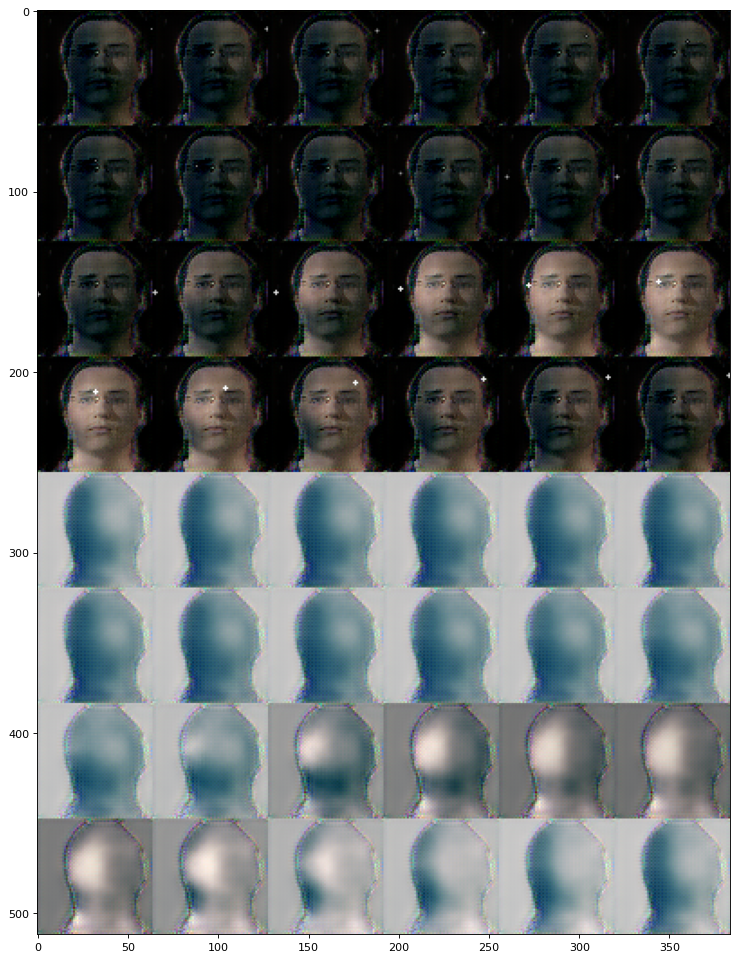

In [528]:
plt.figure(figsize=(15, 15), dpi=80)
plt.imshow(np.concatenate([
    np.concatenate(anim_albedos[0:6], axis=1),
    np.concatenate(anim_albedos[6:12], axis=1),
    np.concatenate(anim_albedos[12:18], axis=1),
    np.concatenate(anim_albedos[18:24], axis=1),
    np.concatenate(anim_preds_norm[0:6], axis=1),
    np.concatenate(anim_preds_norm[6:12], axis=1),
    np.concatenate(anim_preds_norm[12:18], axis=1),
    np.concatenate(anim_preds_norm[18:24], axis=1),
], axis=0                  
))

In [529]:
images_array = (np.clip(anim_albedos, 0, 1) * 255).astype(np.uint8)
images = []
for img in images_array:
    images.append(Image.fromarray(img).resize((128, 128)))

images[0].save('head_light.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,  # Длительность каждого кадра в миллисекундах
               loop=0)  # 0 - бесконечный цикл

In [435]:
dude_depth.shape

(64, 64)

In [531]:
#model.save("human_nn_relight_good.keras")
# Эта хорошо показывает себя в целом не плохо